# The FIRS Level-2 data product

FIRS is a slit spectropolarimeter at the DST. It rasters a slit across the solar surface, and gets a spectrum in Stokes I, Q, U, and V as it does so, allowing for measurements of temperature, velocity, and the magnetic field. Currently, it is operated on the He I 10830 Angstrom line, which is formed in the upper chromosphere. The spectral window used by FIRS also contains the Si I 10827 Angstrom line, which is formed in the photosphere. Together, these lines can be used to get atmospheric parameters at two different formation environments simultaneously.

## Hazel

The Level-2 FIRS product is the result of spectropolarimetric inversions to determine these atmospheric parameters. The inversion is carried out using the Hazel code, which assumes a single slab of chromospheric material. Atmospheric parameters in this material are varied, and a resulting He I 10830 spectrum is synthesized from the model atmosphere. By matching this synthesized spectrum to the data, you are effectively fitting for atmospheric parameters. Hazel also contains a wrapper to do this for the Si I 10827 line through a different code called SIR, which works on photospheric lines. SIR does its atmospheric parameters over a range of optical depths, which are a proxy for height.

The inversions are already done for you if you're using FIRS data, and neatly packages in FITS format. This tutorial will walk you through extracting different atmospheric parameters that are the result of FIRS inversions.

In [1]:
# First, we set up some generic imports

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits

In [2]:
# Read the FIRS file (you'll have to replace the path/name with your file)
f = fits.open("Downloads/firs_hazel_SiI_HeI_20210504_134810_l2.fits")

## FITS Files

The Level-2 files have a lot of information packed in them. Inversions are tricky to do, and it's important to have as much information as possible to be able to use someone else's inversions for science purposes. To fit all of this information in one file, the Level-2 FIRS files use multiple extensions, each containing broadly one thing. We can see what are in these extensions at a quicklook with the .info() procedure on the astropy.io.fits class:

In [3]:
f.info()

Filename: Downloads/firs_hazel_SiI_HeI_20210504_134810_l2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  CHROMOSPHERE    1 BinTableHDU     82   1R x 18C   [20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D]   
  2  PHOTOSPHERE    1 BinTableHDU     73   73R x 16C   [D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500D, 20500I, 20500I]   
  3  Stokes-I/Ic    1 ImageHDU        25   (195, 164, 125)   float64   
  4  Stokes-Q/Ic    1 ImageHDU        25   (195, 164, 125)   float64   
  5  Stokes-U/Ic    1 ImageHDU        25   (195, 164, 125)   float64   
  6  Stokes-V/Ic    1 ImageHDU        25   (195, 164, 125)   float64   
  7  SYNTHETICStokes-I    1 ImageHDU        25   (195, 164, 125)   float64   
  8  SYNTHETICStokes-Q    1 ImageHDU        25   (195, 164, 125)   float6

# The Layout
There are 13 total extensions in this file. Each has a descriptive name, and the .info() procedure shows their type, dimensions, format as well. While the names are helpful, they aren't complete information.

0. PRIMARY: There is no data in this extension. The header contains useful information, but it's considered best practices by the FITS standard not to have any information in the 0th extension in a FITS file. Other data in the SSOC archive *do* have data in the 0th extension, but going forward, we're trying to avoid this.
1. CHROMOSPHERE: This extension contains the chromospheric inversion results. Note that the "Type" in .info() is "BinTableHDU". Since many parameters are inverted at once, we store these in a table. That way we can call the different parameters by name.
2. PHOTOSPHERE: These are the photospheric inversion results. This extension is also a table.
3. Stokes-I/Ic: This extension contains the Stokes-I data that were given to Hazel. This is useful if you want to check the goodness of fit for a specific point. Ic here referes to the fact that the data are normalized by the disk-center continuum intensity.
4. Stokes-Q/Ic: Stokes-Q data given to Hazel.
5. Stokes-U/Ic: Stokes-U data given to Hazel.
6. Stokes-V/Ic: Stokes-V data given to Hazel
7. SYNTHETICStokes-I: This extension contains the inverted profile that Hazel created to fit the data in extension 3. If you want to check the fit against the data, extracting the same point in extensions 3 and 7 will give you the original and the fit profile.
8. SYNTHETICStokes-Q: Stokes-Q data from Hazel inversion
9. SYNTHETICStokes-U: Stokes-U data from Hazel inversion
10. SYNTHETICStokes-V: Stokes-V data from Hazel inversion
11. CHISQ: This extension contains the map of chi-squared values from the inversion. It's a 2D image that can be used for checking the fit quality across the instrument field-of-view
12. lambda-coordinate: This extension contains the wavelength array corresponding to the spectral data in extensions 3-10. It's the wavelength grid used by Hazel to compute velocities, temperatures, etc.

## First Steps:
That said, sometimes it's good to look at the 0th extension header, just to see what to expect.

In [4]:
f[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-04-26T19:58:07' / File created                                  
ORIGIN  = 'NMSU/SSOC'                                                           
TELESCOP= 'DST     '                                                            
INSTRUME= 'FIRS    '                                                            
DATA_LEV=                    2                                                  
DATE_OBS= '2021-05-04T13:48:16.067'                                             
STARTOBS= '2021-05-04T13:48:16.067'                                             
DATE_END= '2021-05-04T14:24:19.063'                                             
ENDOBS  = '2021-05-04T14:24:

There's not too much here, just basic information. The important parameters are STARTOBS/DATE_OBS and ENDOBS/DATE_END. These are the start and end of the observations in the file.

FOVX and FOVY contain the field-of-view in the X and Y direction. XCEN and YCEN are the center of the data maps in Solar-X and Solar-Y. ROT is the rotation relative to Solar-North. You'll note this is a very small value for this map. **Later extensions also contain this information (in the standard WCS format for compatibility with sunpy), but the 0th extension header has it as well to be human-readable.** Extension 0 is all about readability.

The PRSTEP keywords are a summary of all the processing steps carried out on this data. You'll note that PRSTEP5 is "HAZEL2-INVERSION". That's the last thing that was done to the data.

Now let's take a look at the Chromospheric extension. You can call this as either [1] or ["CHROMOSPHERE"]:

In [6]:
f["CHROMOSPHERE"].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              2952000 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   18 / number of table fields                         
TTYPE1  = 'Bx      '                                                            
TFORM1  = '20500D  '                                                            
TUNIT1  = 'Gauss   '                                                            
TDIM1   = '(164,125)'                                                           
TTYPE2  = 'Bx_err  '        

This header is not that useful, as it mostly contains information about the table in that extension. Let's take a look at the actual table. We'll start by getting the names of the parameters.

In [11]:
f['CHROMOSPHERE'].data.dtype.names

('Bx',
 'Bx_err',
 'By',
 'By_err',
 'Bz',
 'Bz_err',
 'v',
 'v_err',
 'deltav',
 'deltav_err',
 'tau',
 'tau_err',
 'a',
 'a_err',
 'beta',
 'beta_err',
 'ff',
 'ff_err')

Data shape: (1, 125, 164)
Mean velocity: 3.6741875189258475 km/s
Median velocity: 2.261095435021627 km/s
Minimum velocity: -49.99981682116351 km/s
Maximum velocity: 49.493160995304834 km/s


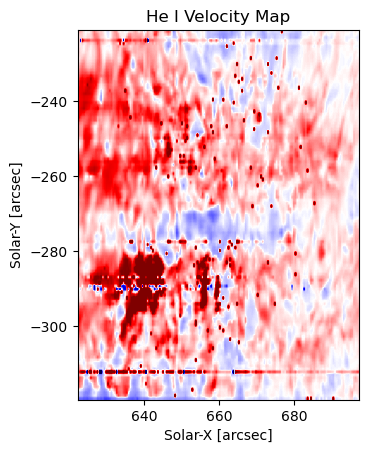

In [19]:
# Let's look at velocity
velocity = f['CHROMOSPHERE'].data['v']
print("Data shape:",velocity.shape)
# Get rid of the 1-size leading axis. 
# This is here because technically, Hazel can stack multiple chromosphere slabs.
# My pipeline is written blindly, so if you HAVE multiple slabs, the table also stacks
# the slabs. If you had a second chromosphere slab, velocity would be of shape (2, ny, nx)
# Since we don't by default, we can just select 0 here:
velocity = velocity[0, :, :]
print("Mean velocity:", np.nanmean(velocity), "km/s")
print("Median velocity:", np.nanmedian(velocity), "km/s")
print("Minimum velocity:", np.nanmin(velocity), "km/s")
print("Maximum velocity:", np.nanmax(velocity), "km/s")
# Note that minimum and maximum are both very close to +/-50. 
#That was chosen as the maximum flow speed in inversions. 
# When the code can't fit a parameter very well, it tends towards the extremes.
# Be very wary of the minima and maxima when using inversion-derived parameters.

# Now lets plot it! For now, we'll manually set the extent from the 0th extension.
# There's an easier way to get coordinates from sunpy, but this is okay for a 
# quick look.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(
    velocity, origin='lower', vmin=-25, vmax=25, cmap='seismic',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax.set_title("He I Velocity Map")
ax.set_ylabel("Solar-Y [arcsec]")
ax.set_xlabel("Solar-X [arcsec]")
plt.show()

# That's velocity!
Note the horizontal lines near the top and bottom. These are "hairlines": fiducial marks in the instrument used for alignment purposes. The data along these hairlines can't be used.

Let's take a look at another parameter: tau. This is the optical depth of the chromosphere. If it's large, the chromospheric material is opaque in the He I 10830 line. This is effectively an intensity map of Helium.

Data shape: (1, 125, 164)
Mean tau: 0.291995526400769 (Optical Depth)
Median tau: 0.2532605035636668 (Optical Depth)
Minimum tau: 0.010007588244322282 (Optical Depth)
Maximum tau: 4.869274815980829 (Optical Depth)


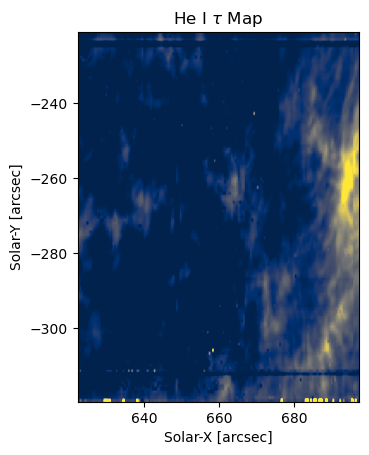

In [26]:
chrom_tau = f['CHROMOSPHERE'].data['tau']
print("Data shape:", chrom_tau.shape)
chrom_tau = chrom_tau[0, :, :]
print("Mean tau:", np.nanmean(chrom_tau), "(Optical Depth)")
print("Median tau:", np.nanmedian(chrom_tau), "(Optical Depth)")
print("Minimum tau:", np.nanmin(chrom_tau), "(Optical Depth)")
print("Maximum tau:", np.nanmax(chrom_tau), "(Optical Depth)")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(
    chrom_tau, origin='lower', vmin=1e-3, vmax=1, cmap='cividis',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax.set_title("He I $\\tau$ Map")
ax.set_ylabel("Solar-Y [arcsec]")
ax.set_xlabel("Solar-X [arcsec]")
plt.show()

# Voila!
That's all there is to extracting chromospheric parameters: list them, find the one you want, and extract it.

## A note:
He I 10830 is sometimes optically thin. When you're using derived parameters, be aware of tau! If tau is small, you may actually be seeing the photosphere shining through!

## Advanced use: filtering by tau
Maybe you only want places where there's a bunch of chromospheric material. Python makes this easy to do! You can filter by tau and apply that filter to, say, velocity. Let's say we're only interested in the velocities in regions where tau >= 0.25:

Mean velocity (filtered): 2.2658761613287997 km/s
Median velocity (filtered): 1.7398136974580325 km/s
Minimum velocity (filtered): -15.073044106961383 km/s
Maximum velocity (filtered): 45.40231592443102 km/s


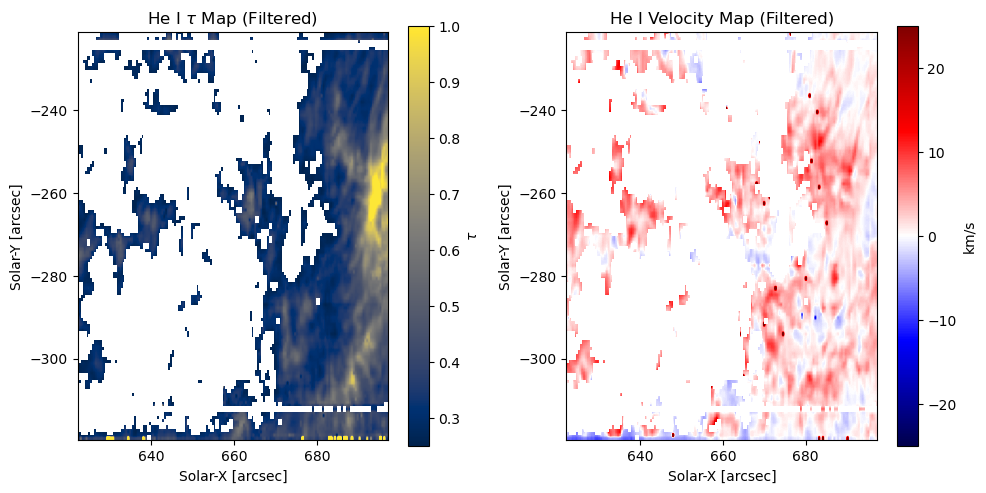

In [39]:
# Creating the mask:
tau_mask = chrom_tau <= 0.25
# Make a copy of the tau map that we can blank out without affecting the original
filtered_tau = chrom_tau.copy()
filtered_tau[tau_mask] = np.nan
# Make a copy of the velocity map for the same purpose
filtered_v = velocity.copy()
filtered_v[tau_mask] = np.nan

print("Mean velocity (filtered):", np.nanmean(filtered_v), "km/s")
print("Median velocity (filtered):", np.nanmedian(filtered_v), "km/s")
print("Minimum velocity (filtered):", np.nanmin(filtered_v), "km/s")
print("Maximum velocity (filtered):", np.nanmax(filtered_v), "km/s")

# We'll add some colorbars this time, just for fun
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
tau_plot = ax.imshow(
    filtered_tau, origin='lower', vmin=0.25, vmax=1, cmap='cividis',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax.set_title("He I $\\tau$ Map (Filtered)")
ax.set_ylabel("Solar-Y [arcsec]")
ax.set_xlabel("Solar-X [arcsec]")
ax2 = fig.add_subplot(122)
vplot = ax2.imshow(
    filtered_v, origin='lower', vmin=-25, vmax=25, cmap='seismic',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax2.set_title("He I Velocity Map (Filtered)")
ax2.set_ylabel("Solar-Y [arcsec]")
ax2.set_xlabel("Solar-X [arcsec]")
plt.colorbar(tau_plot, ax=ax, label="$\\tau$")
plt.colorbar(vplot, ax=ax2, label="km/s")
plt.tight_layout()
plt.show()

# The Photosphere:
The photospheric data is laid out much the same, with one crucial difference: These data are 3D! There's no leading 1-length axis. Let's take a look at what I mean:

In [40]:
f['PHOTOSPHERE'].data.dtype.names

('logTau',
 'Bx',
 'Bx_err',
 'By',
 'By_err',
 'Bz',
 'Bz_err',
 'T',
 'T_err',
 'v',
 'v_err',
 'vmac',
 'vmic',
 'vmic_err',
 'ff',
 'ff_err')

In [42]:
photo_v = f['PHOTOSPHERE'].data['v']
photo_v.shape

(73, 125, 164)

The code that does the photospheric fitting does so on a grid of optical depths. The photosphere is opaque (by definition), but the Si I line samples multiple different depths. The "logTau" parameter is the grid of optical depths used by the inversion code. Let's take a look at that grid, and find the surface (logTau = 0, i.e., tau=1)

In [43]:
f['PHOTOSPHERE'].data['logTau']

array([ 1.2,  1.1,  1. ,  0.9,  0.8,  0.7,  0.6,  0.5,  0.4,  0.3,  0.2,
        0.1,  0. , -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9,
       -1. , -1.1, -1.2, -1.3, -1.4, -1.5, -1.6, -1.7, -1.8, -1.9, -2. ,
       -2.1, -2.2, -2.3, -2.4, -2.5, -2.6, -2.7, -2.8, -2.9, -3. , -3.1,
       -3.2, -3.3, -3.4, -3.5, -3.6, -3.7, -3.8, -3.9, -4. , -4.1, -4.2,
       -4.3, -4.4, -4.5, -4.6, -4.7, -4.8, -4.9, -5. , -5.1, -5.2, -5.3,
       -5.4, -5.5, -5.6, -5.7, -5.8, -5.9, -6. ], dtype='>f8')

In [48]:
f['PHOTOSPHERE'].data['logTau'].shape

(73,)

In [47]:
# numpy.where is very useful, but since it can find multiple occurances in different axes
# it's output is a tuple containing an array. Since logTau has only unique elements,
# to just get the index, we need to take np.where(...)[0][0]
surface_index = np.where(f['PHOTOSPHERE'].data['logTau'] == 0)[0][0]
surface_index

12

Mean photospheric velocity: 1.088097090769441 km/s
Median photospheric velocity: 1.0756535073006468 km/s
Minimum photospheric velocity: -0.822064728479976 km/s
Maximum photospheric velocity: 2.990854881248561 km/s


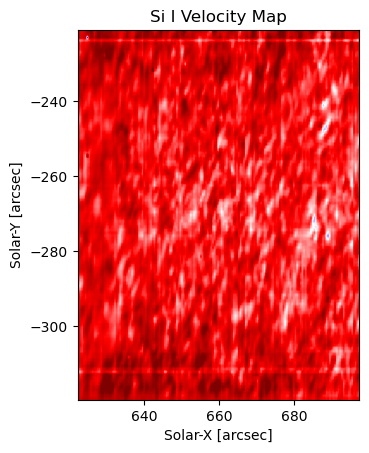

In [51]:
surface_v = photo_v[surface_index, :, :]
# Now we have a map of the same shape as the chromospheric maps!
print("Mean photospheric velocity:", np.nanmean(surface_v), "km/s")
print("Median photospheric velocity:", np.nanmedian(surface_v), "km/s")
print("Minimum photospheric velocity:", np.nanmin(surface_v), "km/s")
print("Maximum photospheric velocity:", np.nanmax(surface_v), "km/s")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(
    surface_v, origin='lower', vmin=-2, vmax=2, cmap='seismic',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax.set_title("Si I Velocity Map")
ax.set_ylabel("Solar-Y [arcsec]")
ax.set_xlabel("Solar-X [arcsec]")
plt.show()

# That's awfully red.

This can happen when the wavelength correction used isn't quite perfect! Fortunately, it's pretty small (The maximum velocity is only 3 km/s), and we can do a rough correction for it pretty easily by subtracting off the median velocity from the velocity map:

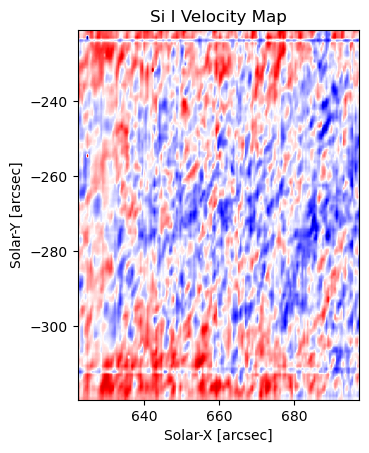

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(
    surface_v - np.nanmedian(surface_v), origin='lower', vmin=-2, vmax=2, cmap='seismic',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax.set_title("Si I Velocity Map")
ax.set_ylabel("Solar-Y [arcsec]")
ax.set_xlabel("Solar-X [arcsec]")
plt.show()

That's a bit better! There may still be biases, but now we're closer to everything looking good.

We can also apply our filter from before! This is useful if you want to study flows through the atmosphere.

While we're at it, we can also check out the flows in the upper photosphere by selecting a smaller tau, and seeing if it's different! We'll select the second-to-last, logTau = -5.9

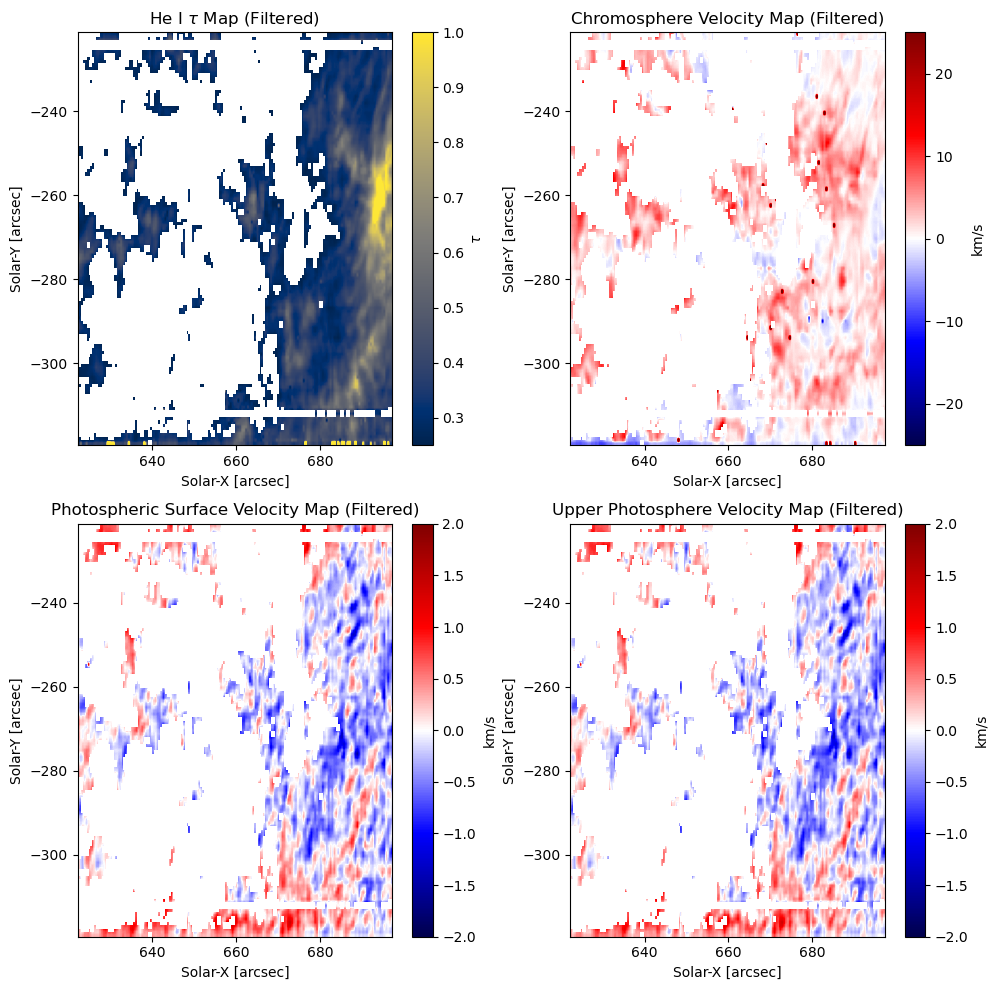

In [66]:
filtered_surface_v = surface_v - np.nanmedian(surface_v)
filtered_surface_v[tau_mask] = np.nan

upper_photosphere_v = photo_v[-2, :, :] - np.nanmedian(surface_v)
upper_photosphere_v[tau_mask] = np.nan

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
tau_plot = ax.imshow(
    filtered_tau, origin='lower', vmin=0.25, vmax=1, cmap='cividis',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax.set_title("He I $\\tau$ Map (Filtered)")
ax.set_ylabel("Solar-Y [arcsec]")
ax.set_xlabel("Solar-X [arcsec]")

ax2 = fig.add_subplot(222)
vplot = ax2.imshow(
    filtered_v, origin='lower', vmin=-25, vmax=25, cmap='seismic',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax2.set_title("Chromosphere Velocity Map (Filtered)")
ax2.set_ylabel("Solar-Y [arcsec]")
ax2.set_xlabel("Solar-X [arcsec]")

ax3 = fig.add_subplot(223)
svplot = ax3.imshow(
    filtered_surface_v, origin='lower', vmin=-2, vmax=2, cmap='seismic',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax3.set_title("Photospheric Surface Velocity Map (Filtered)")
ax3.set_ylabel("Solar-Y [arcsec]")
ax3.set_xlabel("Solar-X [arcsec]")

ax4 = fig.add_subplot(224)
pvplot = ax4.imshow(
    upper_photosphere_v, origin='lower', vmin=-2, vmax=2, cmap='seismic',
    extent=[
        f[0].header['XCEN'] - 0.5*f[0].header['FOVX'],
        f[0].header['XCEN'] + 0.5*f[0].header['FOVX'],
        f[0].header['YCEN'] - 0.5*f[0].header['FOVY'],
        f[0].header['YCEN'] + 0.5*f[0].header['FOVY']
    ]
)
ax4.set_title("Upper Photosphere Velocity Map (Filtered)")
ax4.set_ylabel("Solar-Y [arcsec]")
ax4.set_xlabel("Solar-X [arcsec]")

plt.colorbar(tau_plot, ax=ax, label="$\\tau$")
plt.colorbar(vplot, ax=ax2, label="km/s")
plt.colorbar(svplot, ax=ax3, label='km/s')
plt.colorbar(pvplot, ax=ax4, label='km/s')

plt.tight_layout()
plt.show()

# Looking at the fits:
There's a pretty optically-dense blob of plasma on the right-hand side of these maps. Let's extract a point from the blob and see what the fit in there looks like.

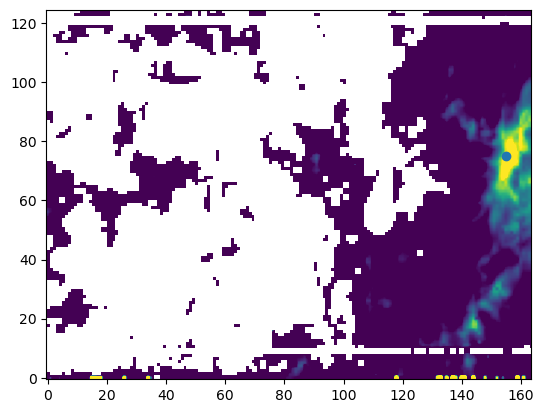

In [72]:
yidx = 75
xidx = 155

plt.imshow(filtered_tau, vmin=0.5, vmax=1,origin='lower')
plt.plot([xidx], [yidx], marker='o')
plt.show()

I just picked X=155, y=75 at random from that plot, and put a marker on it.

Let's take a look at it:

In [76]:
# First, grab the wavelength grid, and let's see what we're working with:
wavelength_array = f['lambda-coordinate'].data
print(wavelength_array.min())
print(wavelength_array.max())
print(wavelength_array.shape)

10824.013675710075
10831.465275245935
(195,)


In [74]:
# Now let's take a look at the Stokes-I extension header: 
f['Stokes-I/Ic'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  195                                                  
NAXIS2  =                  164                                                  
NAXIS3  =                  125                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'Stokes-I/Ic'        / Normalized by Quiet Sun, Corrected for position
CDELT1  =                  0.6 / arcsec                                         
CDELT2  =                  0.6 / arcsec                                         
CDELT3  =  0.03841030688636238                                                  
CTYPE1  = 'HPLN-TAN'        

# Hang on, that header looks different...
It is! The stokes extensions all use WCS standard keywords. The keywords starting with "C" are standard FITS header keywords. These are readable by pretty much anything that parses coordinates, including Sunpy. The CHISQ extension also uses these keywords. Keep that in mind; it's a surprise tool that'll help us later.

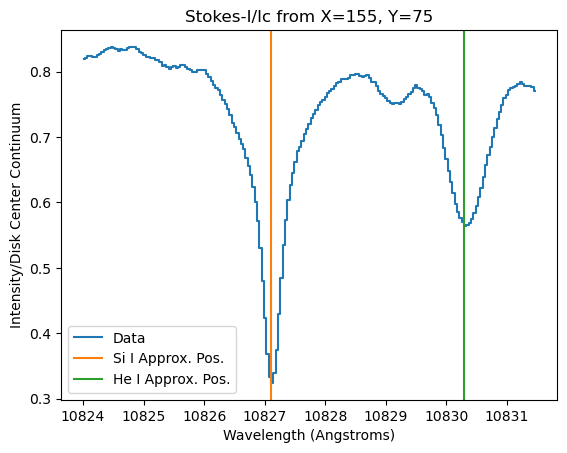

In [90]:
f['Stokes-I/Ic'].data.shape
# Here, axis 2 matches wavelength.
stokes_i = f['Stokes-I/Ic'].data[yidx, xidx, :]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wavelength_array, stokes_i, drawstyle='steps-mid',label='Data')
ax.set_ylabel("Intensity/Disk Center Continuum")
ax.set_xlabel("Wavelength (Angstroms)")
ax.axvline(10827.1, c='C1', label='Si I Approx. Pos.')
ax.axvline(10830.3, c='C2', label='He I Approx. Pos.')
ax.set_title("Stokes-I/Ic from X="+str(xidx)+", Y="+str(yidx))
ax.legend()
plt.show()

# Let's grab the same point in Q, U, and V

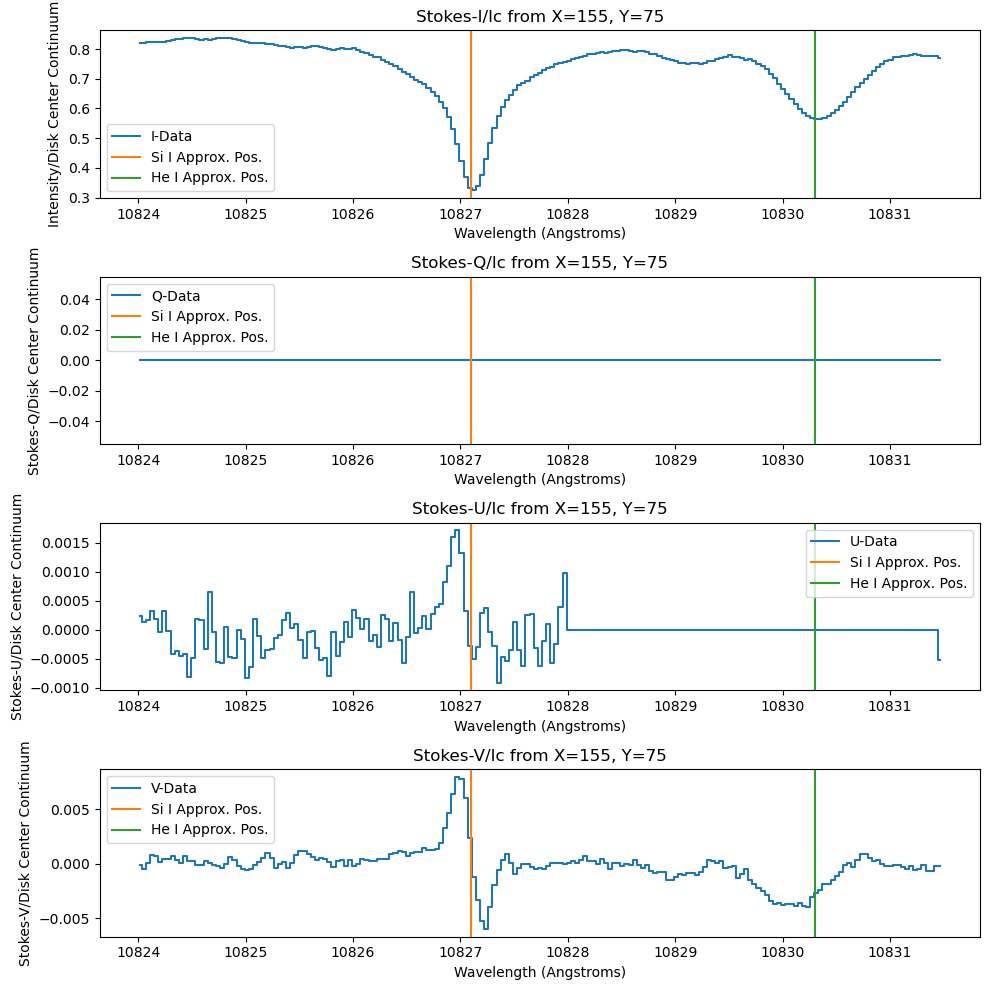

In [94]:
stokes_q = f['Stokes-Q/Ic'].data[yidx, xidx, :]
stokes_u = f['Stokes-U/Ic'].data[yidx, xidx, :]
stokes_v = f['Stokes-V/Ic'].data[yidx, xidx, :]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(411)
ax.plot(wavelength_array, stokes_i, drawstyle='steps-mid',label='I-Data')
ax.set_ylabel("Intensity/Disk Center Continuum")
ax.set_xlabel("Wavelength (Angstroms)")
ax.axvline(10827.1, c='C1', label='Si I Approx. Pos.')
ax.axvline(10830.3, c='C2', label='He I Approx. Pos.')
ax.set_title("Stokes-I/Ic from X="+str(xidx)+", Y="+str(yidx))
ax.legend()

ax2 = fig.add_subplot(412)
ax2.plot(wavelength_array, stokes_q, drawstyle='steps-mid',label='Q-Data')
ax2.set_ylabel("Stokes-Q/Disk Center Continuum")
ax2.set_xlabel("Wavelength (Angstroms)")
ax2.axvline(10827.1, c='C1', label='Si I Approx. Pos.')
ax2.axvline(10830.3, c='C2', label='He I Approx. Pos.')
ax2.set_title("Stokes-Q/Ic from X="+str(xidx)+", Y="+str(yidx))
ax2.legend()

ax3 = fig.add_subplot(413)
ax3.plot(wavelength_array, stokes_u, drawstyle='steps-mid',label='U-Data')
ax3.set_ylabel("Stokes-U/Disk Center Continuum")
ax3.set_xlabel("Wavelength (Angstroms)")
ax3.axvline(10827.1, c='C1', label='Si I Approx. Pos.')
ax3.axvline(10830.3, c='C2', label='He I Approx. Pos.')
ax3.set_title("Stokes-U/Ic from X="+str(xidx)+", Y="+str(yidx))
ax3.legend()

ax4 = fig.add_subplot(414)
ax4.plot(wavelength_array, stokes_v, drawstyle='steps-mid',label='V-Data')
ax4.set_ylabel("Stokes-V/Disk Center Continuum")
ax4.set_xlabel("Wavelength (Angstroms)")
ax4.axvline(10827.1, c='C1', label='Si I Approx. Pos.')
ax4.axvline(10830.3, c='C2', label='He I Approx. Pos.')
ax4.set_title("Stokes-V/Ic from X="+str(xidx)+", Y="+str(yidx))
ax4.legend()

plt.tight_layout()
plt.show()

# Why is some of it flat?
This dataset was taken along a coronal hole boundary. There's only a very small amount of magnetic field strength. In regions where there is no significant signal in Q, U, or V, my preprocessing code sets the profile to zeros. It does this for Si I and He I separately. That's why, in Stokes-U, the Si I profile is there, but the He I profile is flat.

## Now let's get the fit profiles and lay them over top.

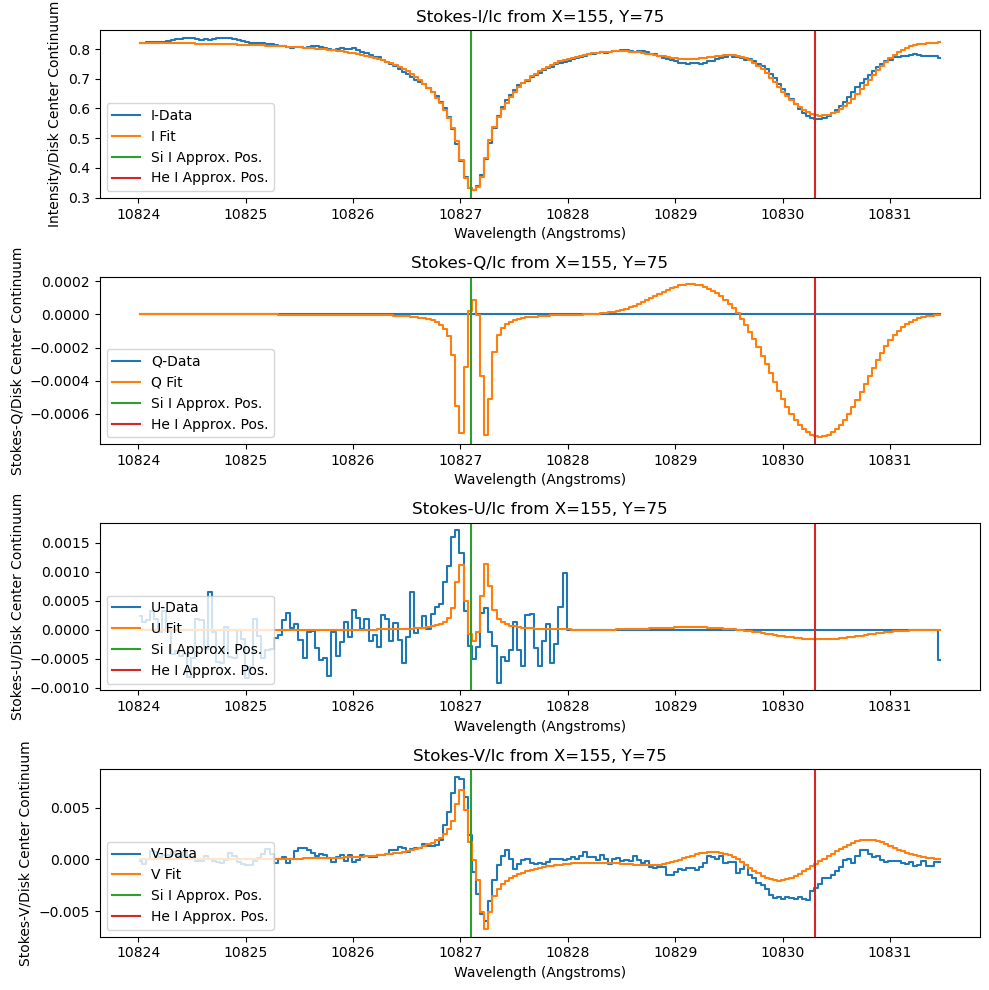

In [96]:
synth_stokes_i = f['SYNTHETICStokes-I'].data[yidx, xidx, :]
synth_stokes_q = f['SYNTHETICStokes-Q'].data[yidx, xidx, :]
synth_stokes_u = f['SYNTHETICStokes-U'].data[yidx, xidx, :]
synth_stokes_v = f['SYNTHETICStokes-V'].data[yidx, xidx, :]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(411)
ax.plot(wavelength_array, stokes_i, drawstyle='steps-mid',label='I-Data')
ax.plot(wavelength_array, synth_stokes_i, drawstyle='steps-mid', label='I Fit')
ax.set_ylabel("Intensity/Disk Center Continuum")
ax.set_xlabel("Wavelength (Angstroms)")
ax.axvline(10827.1, c='C2', label='Si I Approx. Pos.')
ax.axvline(10830.3, c='C3', label='He I Approx. Pos.')
ax.set_title("Stokes-I/Ic from X="+str(xidx)+", Y="+str(yidx))
ax.legend(loc='lower left')

ax2 = fig.add_subplot(412)
ax2.plot(wavelength_array, stokes_q, drawstyle='steps-mid',label='Q-Data')
ax2.plot(wavelength_array, synth_stokes_q, drawstyle='steps-mid', label='Q Fit')
ax2.set_ylabel("Stokes-Q/Disk Center Continuum")
ax2.set_xlabel("Wavelength (Angstroms)")
ax2.axvline(10827.1, c='C2', label='Si I Approx. Pos.')
ax2.axvline(10830.3, c='C3', label='He I Approx. Pos.')
ax2.set_title("Stokes-Q/Ic from X="+str(xidx)+", Y="+str(yidx))
ax2.legend(loc='lower left')

ax3 = fig.add_subplot(413)
ax3.plot(wavelength_array, stokes_u, drawstyle='steps-mid',label='U-Data')
ax3.plot(wavelength_array, synth_stokes_u, drawstyle='steps-mid', label='U Fit')
ax3.set_ylabel("Stokes-U/Disk Center Continuum")
ax3.set_xlabel("Wavelength (Angstroms)")
ax3.axvline(10827.1, c='C2', label='Si I Approx. Pos.')
ax3.axvline(10830.3, c='C3', label='He I Approx. Pos.')
ax3.set_title("Stokes-U/Ic from X="+str(xidx)+", Y="+str(yidx))
ax3.legend(loc='lower left')

ax4 = fig.add_subplot(414)
ax4.plot(wavelength_array, stokes_v, drawstyle='steps-mid',label='V-Data')
ax4.plot(wavelength_array, synth_stokes_v, drawstyle='steps-mid', label='V Fit')
ax4.set_ylabel("Stokes-V/Disk Center Continuum")
ax4.set_xlabel("Wavelength (Angstroms)")
ax4.axvline(10827.1, c='C2', label='Si I Approx. Pos.')
ax4.axvline(10830.3, c='C3', label='He I Approx. Pos.')
ax4.set_title("Stokes-V/Ic from X="+str(xidx)+", Y="+str(yidx))
ax4.legend(loc='lower left')

plt.tight_layout()
plt.show()

# What happened?

The fits look pretty good in Stokes I, Si I Stokes-U, and Stokes-V. However, Stokes-Q has fits when there's no signal. Same with He I stokes U. Since Stokes-V corresponds to magnetic field strength (Or "Bz" in the chromosphere and photosphere extensions), you can probably use those values.

### The code in these regions fit the noise
There is a noise level fed to Hazel along with the signal. It can't be zeroed out without breaking things. So in regions with no signal, it still fits to the tolerance of the noise. This can result in some spurious signals. Be very careful. Future releases of FIRS Level-2 data will do some extra filtering after the fact to zero out these bad results, but for right now, just know that this can happen. In general, if something looks weird, it probably is.

As an exercise to the reader, you can use the Stokes-I,Q,U,V/Ic extensions as filters natively using similar techniques to above.

## The Chi Squared Extension:
Before we wrap up entirely, let's take a look at the Chi-squared extension, and use that to help us make a Sunpy Map.

In [97]:
f['CHISQ'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  164                                                  
NAXIS2  =                  125                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'CHISQ   '           / Fit chi-square from Hazel Inversions           
CDELT1  =                  0.6 / arcsec                                         
CDELT2  =                  0.6 / arcsec                                         
CTYPE1  = 'HPLN-TAN'                                                            
CTYPE2  = 'HPLT-TAN'                                                            
CUNIT1  = 'arcsec  '        

This extension just has a single, 2D map of chisquare data. You can use this to filter your parameter arrays as well, but the header is very useful for making sunpy maps. Let's take a look at the data real quick first:

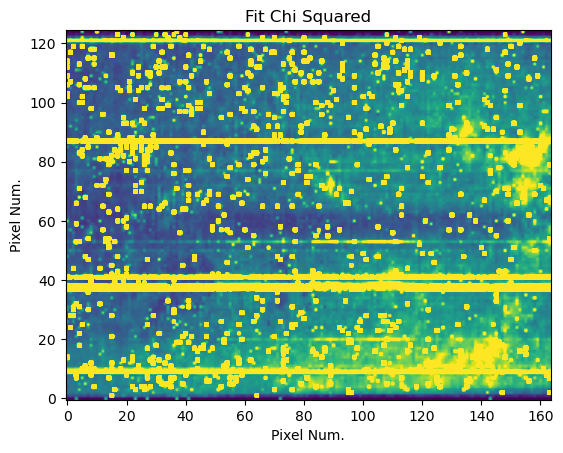

In [101]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(f['CHISQ'].data, origin='lower', vmin=0, vmax=15)
ax.set_title("Fit Chi Squared")
ax.set_xlabel("Pixel Num.")
ax.set_ylabel("Pixel Num.")
plt.show()

Chi Square is calculated from all four Stokes vector fits. As a result, it can be pretty high in certain areas, but that's usually okay!

# Sunpy Maps (Advanced)
## DISCLAIMER
Before you go any further;
1. Make sure you have sunpy installed
2. Know that DST coordinates are NOT ACCURATE. You CANNOT just overlay this on an AIA map and work from there. The DST is VERY OLD and it DOES NOT know where it is. These coordinates are a best guess. I'm working on an alignment code, but it's tricky on regions of quiet Sun, which this is. If you can't wait for me to finish testing the code, it lives here:
https://github.com/sgsellers/dstAlign
It works on sunspot data as-is, but is unreliable elsewhere. This is under active development, so there is no manual. Read the docstrings on the individual functions, or wait for a future release.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


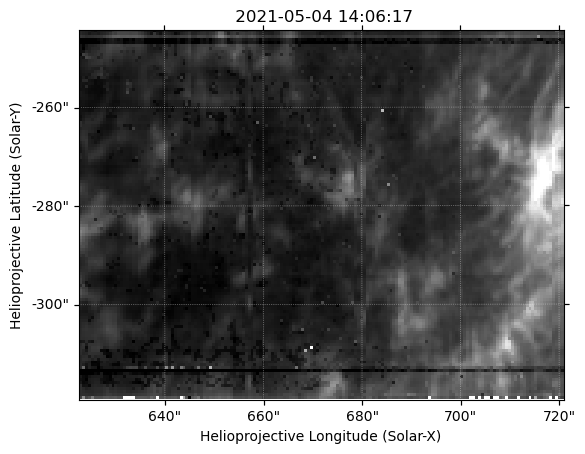

In [109]:
import sunpy.map as smap

start_time = np.datetime64(f[0].header['STARTOBS'])
end_time = np.datetime64(f[0].header['ENDOBS'])
elapsed_time = end_time - start_time
avg_time = start_time + elapsed_time/2

chisq_header = f['CHISQ'].header
chisq_header['DATE-AVG'] = avg_time.astype(str)

chromosphere_tau_map = smap.Map(chrom_tau, f['CHISQ'].header)
chromosphere_tau_map.plot(vmin=0.1, vmax=1)
plt.show()

# What did we do?
Sunpy maps are powerful tools containing information about coordinates, data, and other parameters. They're a helpful container for analyzing solar data. Typically, sunpy maps are made from fits files that contain a single extension. For more complicated data, like this, you can either assemble a header dictionary containing all the "C" values, OR, know that the Chi Squared header is already nearly-ready for Sunpy. It just needs a time. You can supply it from the STARTOBS and ENDOBS keywords from the primary header.

You can also leave it blank, in which case, sunpy assumes current time. If you're not coordinating with other instruments, that's usually fine. But now that the header is set up, we can use it with any other parameter. Let's try it out on Photospheric Bz, a parameter we haven't used yet. We'll filter it by the chromospheric tau, put it in a map, and plot it.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


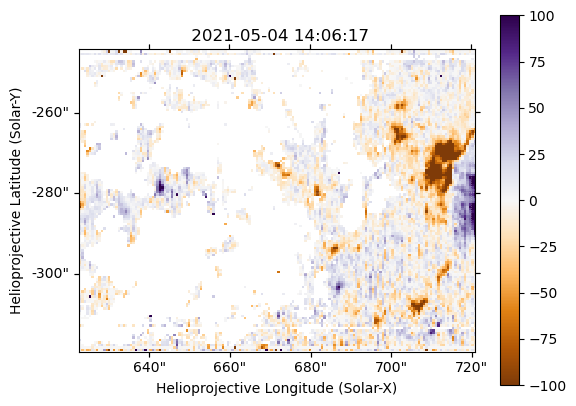

In [117]:
bz_phot = f['PHOTOSPHERE'].data['Bz'][surface_index]
bz_phot[tau_mask] = np.nan

bz_map = smap.Map(bz_phot, chisq_header)
bz_map.plot_settings['cmap'] = 'PuOr'
bz_map.plot(vmin=-100, vmax=100)
plt.colorbar()
plt.show()

# That's all I've got time for at this very second, but let me know if you have any more questions!